# Programming for Data Analytics Project
# Analysis of Wind Speed and Wind Energy in Ireland

*Author: Eoghan Walsh*
***

This project uses Python and various libraries to analyse wind speed and wind energy in Ireland and aims to identify possible trends in hourly and monthly wind speed data, explore the relationship between energy demand and wind energy generation, and predict future wind speed.
* Data Visualisation: Plot wind speed and energy data using ``matplotlib`` and ``seaborn``.
* Trend Analysis: Identify seasonal trends in the data.
* Prediction: Use ``scikit-learn``'s decision tree regression to forecast future wind speeds.

## Import the Modules

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import csv
import re
import requests
from io import StringIO
from sklearn import tree

## Import and Clean the Hourly Wind Speed Data

I'm using [Met Eireann's](https://www.met.ie/climate/available-data/historical-data) historical datasets to obtain the wind speed data for Ireland. The hourly data was observed at 25 synoptic weather stations across the country. The wind speed is measured as the mean wind speed in knots.

In [99]:
# Import and clean the hourly weather date.
def import_hourly_data():

    # File containing URLs to Met Eirean hourly weather data.
    txt_file = './data/download-file-list-hourly.txt'

    # Regex pattern to find the start of useful data in CSV files.
    # https://media.datacamp.com/legacy/image/upload/v1665049611/Marketing/Blog/Regular_Expressions_Cheat_Sheet.pdf
    regex = r'^date(?!:)'

    # Columns to import to dataframe.
    columns = ['date', 'wdsp']

    # Numeric columns.
    numeric_columns = ['wdsp']

    # Index column.
    index = 'date'

    # List to store the dataframes.
    dataframes = []

    # Regex pattern to find the column header row in CSV files,
    # as there are some rows we need to skip to enable import to dataframe.
    regex_pattern = re.compile(regex, re.IGNORECASE)

    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]

    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            # https://realpython.com/python-requests/#the-get-request
            response = requests.get(url)
            if response.status_code != 200:
                print(
                    f'Failed to retrieve the CSV file. Status code: {response.status_code}')
                continue

            # Treat response content as file-like object.
            # https://www.slingacademy.com/article/python-requests-module-handle-csv-response/
            csv_content = response.text
            csv_file = StringIO(csv_content)

            # Find the station name & row with column headers.
            csv_reader = csv.reader(csv_file)
            station_name = ','.join(
                next(csv_reader)
                ).split('Station Name: ')[1].lower().replace(' ', '_')
            for row_number, row in enumerate(csv_reader):
                row_string = ','.join(row)
                if regex_pattern.search(row_string):
                    break
            else:
                print(
                    f'Error finding regex pattern: \'{regex_pattern.pattern}\' in {url}')
                continue

            # Reset the file pointer and import the data to dataframe.
            # https://geekpython.medium.com/moving-and-locating-the-file-pointer-in-python-fa32758f7054
            csv_file.seek(0)
            df = pd.read_csv(csv_file, skiprows=row_number, index_col=index,
                             usecols=columns, low_memory=False)

            # Format and clean the data.

            # Convert index to datetime.
            df.index = pd.to_datetime(df.index, format='%d-%b-%Y %H:%M')

            # Convert data to numeric.
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

            # Replace any blanks with NAs.
            df = df.replace(' ', np.nan)

            # Update column names to include station name.
            df.columns = [f'{station_name}']

            # Append dataframes to list.
            dataframes.append(df)
            print(f'Imported {url} as {station_name}')

        except Exception as e:
            print(f'An error occurred while processing {url} ({station_name}): {e}')
    return dataframes


# Call the function.
dataframes = import_hourly_data()

# Two of the 25 stations (markree and pheonix park) do not have wind speed
# data and therefore will not be imported to the dataframe.

Imported https://cli.fusio.net/cli/climate_data/webdata/hly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/hly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/hly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/hly3904.csv as cork_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/hly532.csv as dublin_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1775.csv as johnstown_castle_2
Imported https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv as knock_airport
Imported https:/

In [100]:
# Combine dataframes and normalize date range based on overlapping date index.
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas-concat
hourly_df = pd.concat(dataframes, axis=1, join='inner')

# Let's take a look.
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129537 entries, 2010-02-25 01:00:00 to 2025-01-01 00:00:00
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   athenry               129488 non-null  float64
 1   ballyhaise            129509 non-null  float64
 2   belmullet             129536 non-null  float64
 3   casement              129533 non-null  float64
 4   claremorris           129330 non-null  float64
 5   cork_airport          129537 non-null  int64  
 6   dublin_airport        129537 non-null  int64  
 7   dunsany               129524 non-null  float64
 8   finner                122116 non-null  float64
 9   gurteen               129502 non-null  float64
 10  johnstown_castle_2    129503 non-null  float64
 11  knock_airport         129537 non-null  float64
 12  mace_head             129445 non-null  float64
 13  malin_head            129485 non-null  float64
 14  moore_park        

## Plots of the Wind Speed and Wind Energy Data

### Average wind speed around the country
Now that the data has been cleaned and imported into a DataFrame, I can begin to visualize it using ``matplotlib``.

By first examining the average wind speed around the country with a horizontal bar graph, I can see that coastal areas receive more wind than inland areas, as expected. Additionally, I have plotted the locations of the weather stations on a map to provide more context.

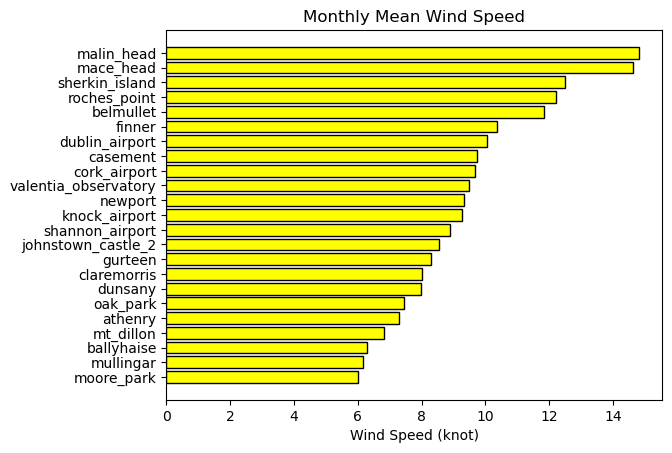

In [101]:
# Let's plot the mean hourly wind speed for each station.
fig, ax = plt.subplots()

# Get the hourly mean for each station.
x = hourly_df.mean().sort_values(ascending=True)

# Horizontal bar chart.
ax.barh(x.index, x, color='yellow', edgecolor='black')

ax.set_title('Monthly Mean Wind Speed')
ax.set_xlabel('Wind Speed (knot)')

plt.show()

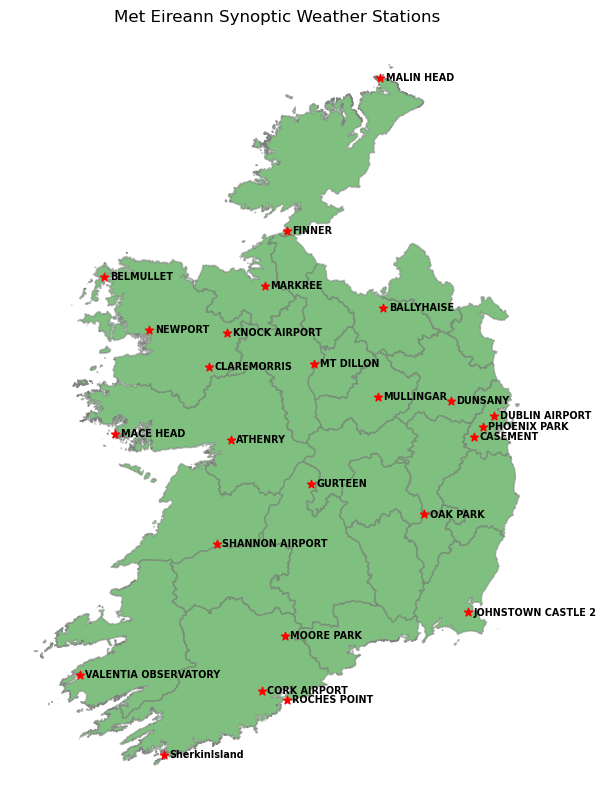

In [118]:
# Generate map from map.py.
%run "map.py"

### Seasonal trends in wind speed

Let's examine whether the wind speed data shows any trends across various times of day or months of the year.

I calculated the correlation between wind speed and the hour of the day as well as the month of the year, and the numbers do not suggest any significant correlation. However, when plotting the data on a scatter plot with a regression line, a seasonal trend becomes apparent. Wind speed appears to be higher in the winter months and lower in the summer months

Hourly correlation: 0.08206980576499133
Monthly correlation: -0.11827531676019234


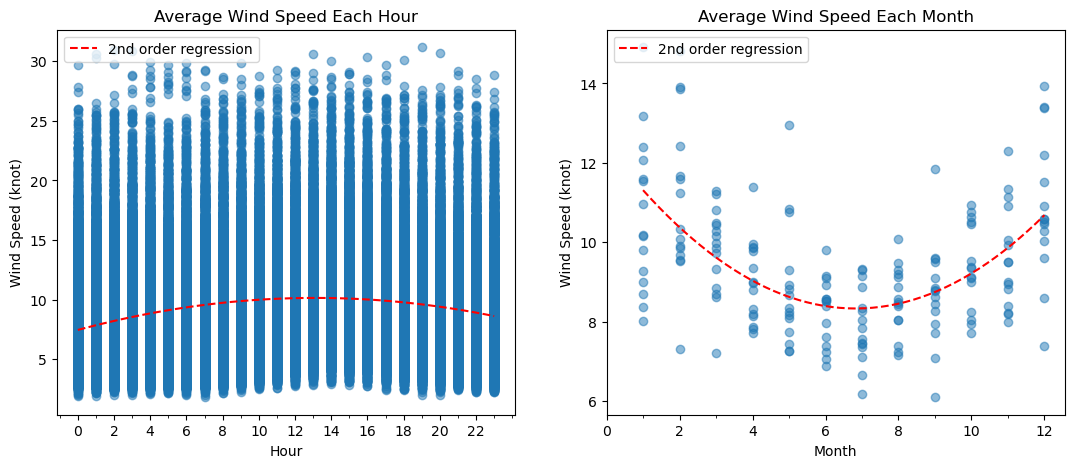

In [119]:
# Let's check if any correlation between the time of day/month and the wind speed.

####
# Create new dataframe with hour and mean wind speed.
hourly_mean = pd.DataFrame(hourly_df.mean(axis=1), columns=['wdsp'])
hourly_mean['hour'] = hourly_mean.index.hour

# Correlation between wind speed and hour.
corr_wind_hour = hourly_mean['hour'].corr(hourly_mean['wdsp'])
print(f'Hourly correlation: {corr_wind_hour}')

# Plot the hourly wind.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

x_h = hourly_mean['hour']
y_h = hourly_mean['wdsp']

ax1.scatter(x_h, y_h, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x_h, y_h, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_h_reg = np.linspace(min(x_h), max(x_h))
y_h_reg = polynomial(x_h_reg)

# Plot the regression line.
ax1.plot(x_h_reg, y_h_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 24, 2)
ax1.set_xticks(xticks)
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.set_xlabel('Hour')
ax1.set_ylabel('Wind Speed (knot)')
ax1.set_title('Average Wind Speed Each Hour')

ax1.legend(loc=2)

####
# Create new dataframe with month and mean wind speed.
monthly_df = hourly_df.resample('MS').mean()

monthly_mean = pd.DataFrame(monthly_df.mean(axis=1), columns=['wdsp'])
monthly_mean['month'] = monthly_df.index.month

# Correlation between wind speed and month.
corr_wind_month = monthly_mean['month'].corr(monthly_mean['wdsp'])
print(f'Monthly correlation: {corr_wind_month}')

# Plot the monthly wind.
x_m = monthly_mean['month']
y_m = monthly_mean['wdsp']

ax2.scatter(x_m, y_m, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
coefficients = np.polyfit(x_m, y_m, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_m_reg = np.linspace(min(x_m), max(x_m))
y_m_reg = polynomial(x_m_reg)

# Plot the regression line.
ax2.plot(x_m_reg, y_m_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 13, 2)
ax2.set_xticks(xticks)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.set_xlabel('Month')
ax2.set_ylabel('Wind Speed (knot)')
ax2.set_title('Average Wind Speed Each Month')

ax2.legend(loc=2)

# Show plot.
plt.show()

### Seasonal trends in wind energy

Using ``seaborn``, I have plotted the correlation between wind energy generation data from the [SEAI](https://www.seai.ie/data-and-insights/seai-statistics/monthly-energy-data/electricity-monthly#comp000064913259000000056f1221) and the month. As expected, wind energy generation follows the same seasonal trend as wind speed, with more energy being generated in the winter months and less in the summer months.

In [104]:
# Let's look at data on electricity generation from wind.
# Import the data.
# https://www.seai.ie/data-and-insights/seai-statistics/monthly-energy-data/electricity-monthly#comp000064913259000000056f1221
seai_csv = './data/seai_wind_gen_data.csv'
seai_df = pd.read_csv(seai_csv)

# Let's clean the data.

# Add datetime column
seai_df['date'] = pd.to_datetime(seai_df['Month of Period'], format='%B %Y')

# Set datetime as index.
seai_df = seai_df.set_index('date')

# Add month column.
seai_df['month'] = seai_df.index.month

Correlation: -0.0017869110205504535


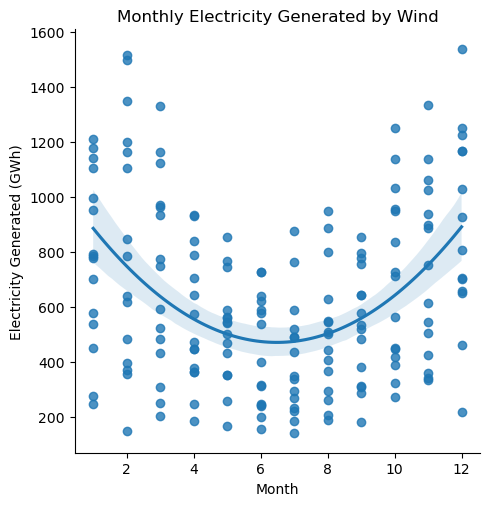

In [105]:
# Let's check if any correlation between the month and the electricity generated.

# Correlation between electricity generated and month.
corr_elec_gen = seai_df['month'].corr(seai_df['Generated'])
print(f'Correlation: {corr_elec_gen}')

# Plot the monthly wind speed and add a regression line.
title = 'Monthly Electricity Generated by Wind'
xlabel = 'Month'
ylabel = 'Electricity Generated (GWh)'

# Seanborn lmplot with 2nd order regression line.
sns.lmplot(data=seai_df, x='month', y='Generated', order=2
           ).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

### Wind speed and wind turbines

Let's explore the relationship between wind speed and wind energy generation.

According to [Wind Europe](https://windeurope.org/about-wind/wind-basics/), wind turbines can generate electricity at wind speeds of 4 to 25 meters per second (m/s). Average wind speeds of 8 m/s or more are considered ideal for operating a wind farm in Ireland, as per the [SEAI](https://www.seai.ie/sites/default/files/publications/Community-Toolkit-Onshore-Wind.pdf).

By revisiting the bar chart from earlier and adding the minimum wind speed needed to operate a wind turbine, we can identify the areas of the country most suitable for viable wind farms.

I have used a conversion rate of 1.94384 to convert m/s to knots.

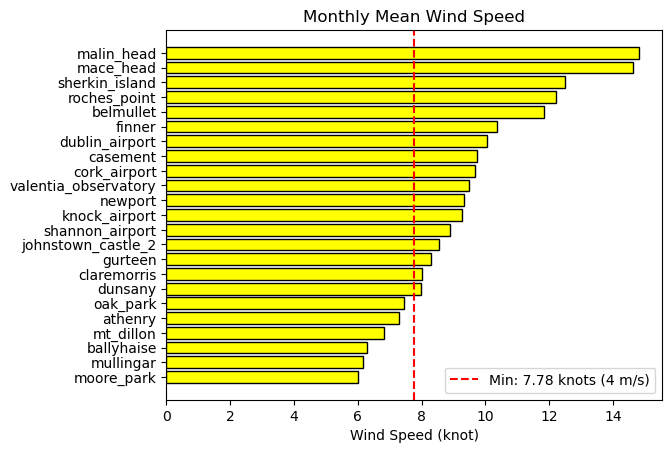

In [106]:
# Let's plot the mean hourly wind speed for each station.
fig, ax = plt.subplots()

# Get the hourly mean for each station.
x = hourly_df.mean().sort_values(ascending=True)

# Horizontal bar chart.
ax.barh(x.index, x, color='yellow', edgecolor='black')

# Add the vertical line
min_m_s = 4
optimal_m_s = 8
max_m_s = 25
conversion = 1.94384
min_value = min_m_s * conversion

ax.axvline(min_value, color='red', linestyle='--',
           label=f'Min: {min_value:.2f} knots ({min_m_s} m/s)')

ax.set_title('Monthly Mean Wind Speed')
ax.set_xlabel('Wind Speed (knot)')
ax.legend()

plt.show()

Below, I have calculated the percentage of time that the minimum wind speed required to operate wind turbines has been reached.

In [107]:
# Let's calculate the % of time that the minimum wind speed is reached for wind turbines.
min_wdsp = 4 * 1.94384
max_wdsp = 25 * 48.5

percentages = {}

for col in hourly_df:
    percentage = ((hourly_df[col] > min_wdsp) & (hourly_df[col] < max_wdsp)
                  ).mean() * 100
    percentages[col] = percentage

# https://www.datacamp.com/tutorial/sort-a-dictionary-by-value-python
sorted_pct = dict(sorted(percentages.items(), key=lambda item: item[1],
                         reverse=True))

for col, pct in sorted_pct.items():
    print(f'{col}: {pct:.2f}%')

malin_head: 83.33%
mace_head: 81.55%
sherkin_island: 74.94%
roches_point: 74.92%
belmullet: 71.22%
dublin_airport: 65.06%
cork_airport: 61.33%
valentia_observatory: 59.89%
finner: 59.42%
casement: 59.28%
newport: 58.33%
knock_airport: 57.73%
shannon_airport: 54.89%
johnstown_castle_2: 52.89%
gurteen: 50.63%
dunsany: 48.93%
claremorris: 48.09%
oak_park: 42.80%
athenry: 42.02%
mt_dillon: 37.87%
ballyhaise: 32.22%
moore_park: 29.94%
mullingar: 29.83%


Below, I have compared the Malin Head, Knock Airport and Mullingar, the areas with the highest, middle, and lowest percentages of time that the wind speed exceeds 4 m/s in a plot.

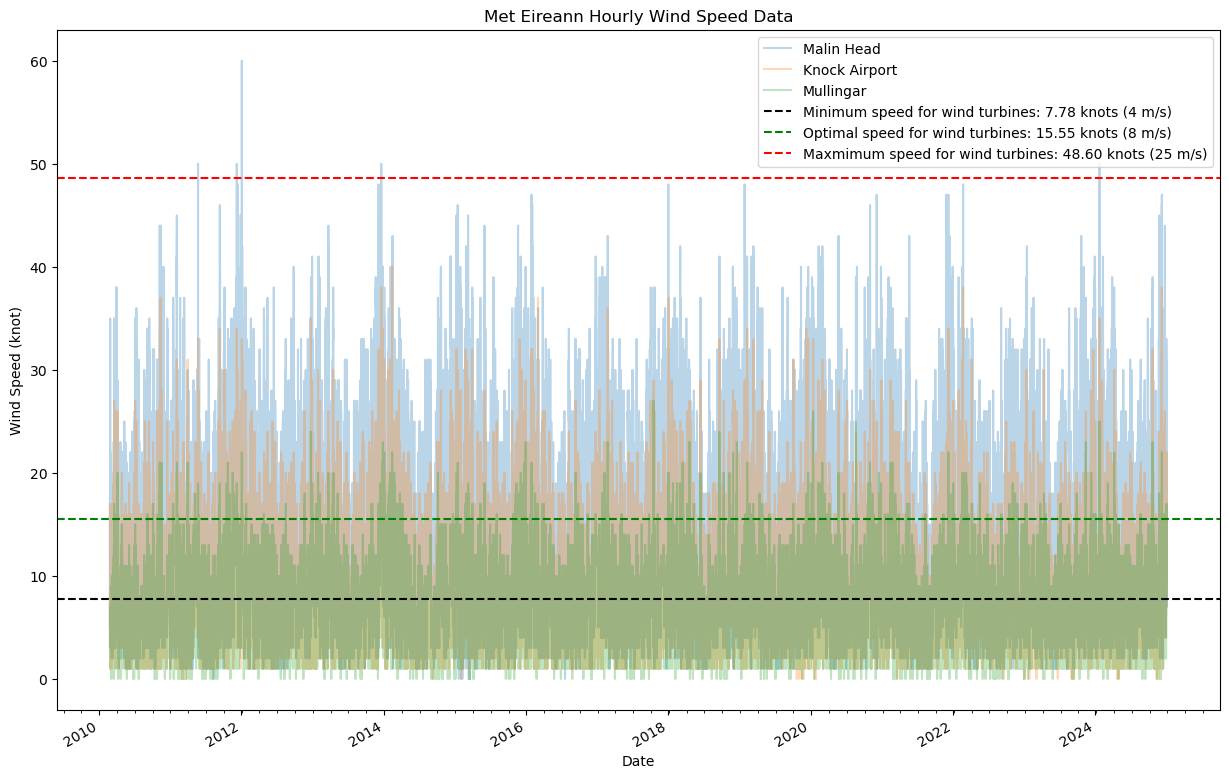

In [108]:
# Plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Malin Head.
ax.plot(hourly_df['malin_head'], alpha=0.3, label='Malin Head')

# Plot Knock Airport.
ax.plot(hourly_df['knock_airport'], alpha=0.3, label='Knock Airport')

# Plot Mullingar.
ax.plot(hourly_df['mullingar'], alpha=0.3, label='Mullingar')

# Add horizontal lines for mean and optimal wind speeds for windfarms.
min_m_s = 4
optimal_m_s = 8
max_m_s = 25
conversion = 1.94384
min_value = min_m_s * conversion
optimal_value = optimal_m_s * conversion
max_value = max_m_s * conversion

ax.axhline(min_value, color='black', linestyle='--',
           label=f'Minimum speed for wind turbines: {min_value:.2f} knots ({min_m_s} m/s)')
ax.axhline(optimal_value, color='green', linestyle='--',
           label=f'Optimal speed for wind turbines: {optimal_value:.2f} knots ({optimal_m_s} m/s)')
ax.axhline(max_value, color='red', linestyle='--',
           label=f'Maxmimum speed for wind turbines: {max_value:.2f} knots ({max_m_s} m/s)')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel('Wind Speed (knot)')
ax.set_xlabel('Date')

ax.set_title('Met Eireann Hourly Wind Speed Data')

ax.legend(loc=1)

plt.show()

### Energy demand and wind energy

Below, I have plotted the electricity demand data from [Eirgrid](https://www.eirgrid.ie/grid/system-and-renewable-data-reports). We can observe that electricity demand has been increasing over the years, and there also appears to be a seasonal trend.

In [109]:
# Wind generation data from eirgrid.
# https://www.eirgrid.ie/grid/system-and-renewable-data-reports
eirgrid_csv = './data/eirgrid_wind_gen_data.csv'

# Import to dataframe.
eirgrid_df = pd.read_csv(eirgrid_csv)

# Let's clean the data.

# Add datetime column.
eirgrid_df['date'] = pd.to_datetime(eirgrid_df['DateTime'],
                                    format='%d/%m/%Y %H:%M')

# Set datetime as index.
eirgrid_df = eirgrid_df.set_index('date')

# Let's drop the DateTime column.
eirgrid_df = eirgrid_df.drop(columns='DateTime')

# Let's add a month and an hour column.
eirgrid_df['month'] = eirgrid_df.index.month
eirgrid_df['hour'] = eirgrid_df.index.hour

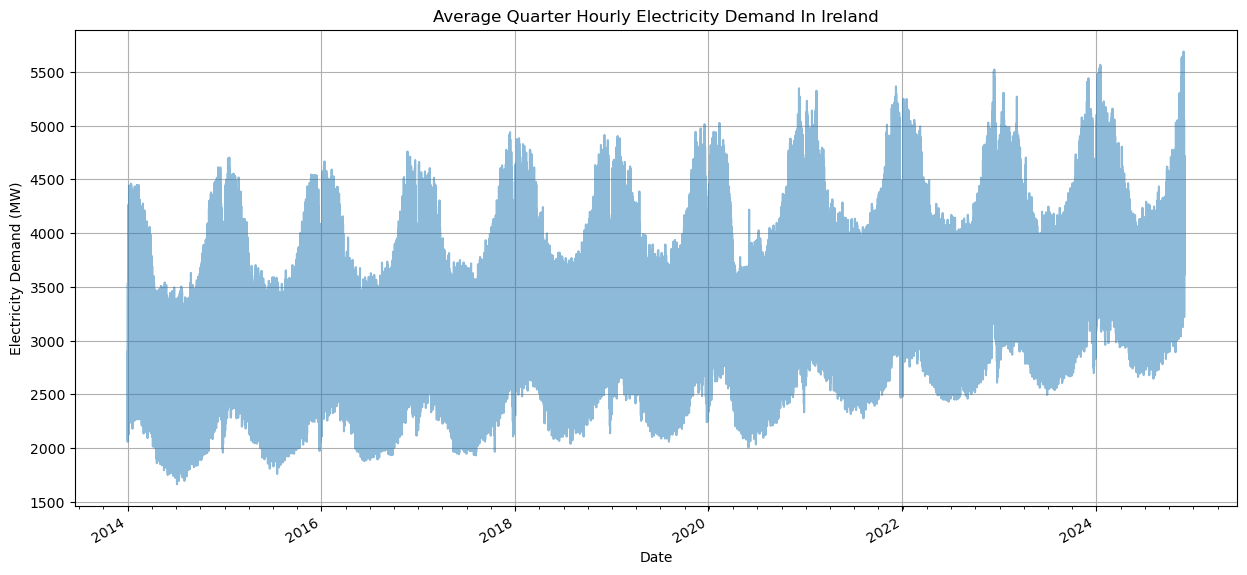

In [110]:
# Plot.
fig, ax = plt.subplots(figsize=(15, 7))

# Plot electricity energy demand.
ax.plot(eirgrid_df['IE Demand'], color='tab:blue', alpha=0.5)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel('Electricity Demand (MW)')
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title('Average Quarter Hourly Electricity Demand In Ireland')

plt.show()

Below, I have further analysed the demand trend by plotting the average demand for each month and each hour. We can again observe a seasonal trend, with electricity demand being higher in the winter months. Additionally, we can see that demand is greater during the daytime and lower at nighttime.

Monthly correlation: -0.049229804544632126
Hourly correlation: 0.5165410896594776


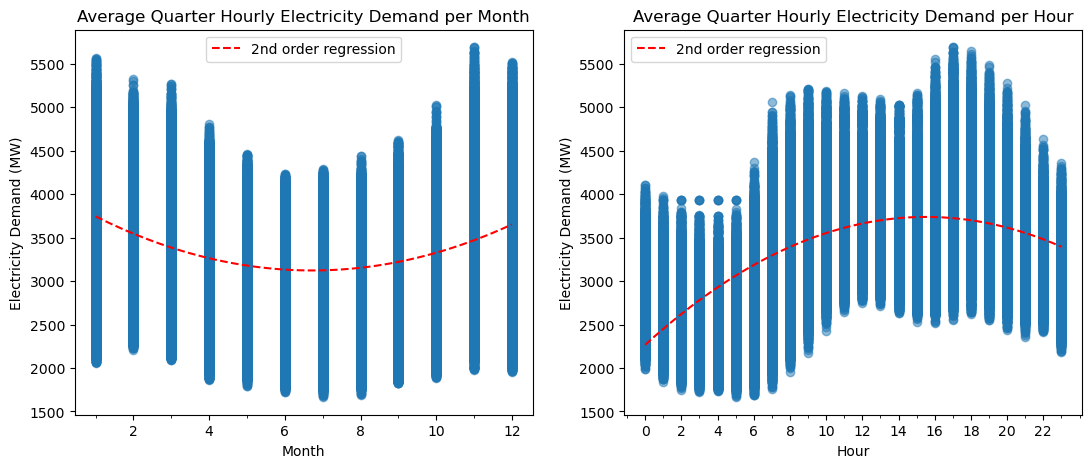

In [111]:
# Let's check if any correlation between the time of day/month and the electricity demand.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

###
# Correlation between electricity demand and month.
corr_elec_month = eirgrid_df['month'].corr(eirgrid_df['IE Demand'])
print(f'Monthly correlation: {corr_elec_month}')

# Plot the electricity demand.
x = eirgrid_df['month']
y = eirgrid_df['IE Demand']

ax1.scatter(x, y, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_reg = np.linspace(min(x), max(x))
y_reg = polynomial(x_reg)

# Plot the regression line.
ax1.plot(x_reg, y_reg, 'r--', label='2nd order regression')

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.set_xlabel('Month')
ax1.set_ylabel('Electricity Demand (MW)')
ax1.set_title('Average Quarter Hourly Electricity Demand per Month')

ax1.legend(loc=9)

# Correlation between electricity demand and hour.
corr_elec_hour = eirgrid_df['hour'].corr(eirgrid_df['IE Demand'])
print(f'Hourly correlation: {corr_elec_hour}')

# Plot the electricity demand.
x = eirgrid_df['hour']
y = eirgrid_df['IE Demand']

ax2.scatter(x, y, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_reg = np.linspace(min(x), max(x))
y_reg = polynomial(x_reg)

# Plot the regression line.
ax2.plot(x_reg, y_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 24, 2)
ax2.set_xticks(xticks)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.set_xlabel('Hour')
ax2.set_ylabel('Electricity Demand (MW)')
ax2.set_title('Average Quarter Hourly Electricity Demand per Hour')

ax2.legend(loc=2)

# Show plot.
plt.show()

### Wind energy share and wind turbine capacity

Below, I have plotted the electricity generation and wind energy generation date from [Eirgrid](https://www.eirgrid.ie/grid/system-and-renewable-data-reports) alongside the [installed wind capacity](https://cms.eirgrid.ie/sites/default/files/publications/System-and-Renewable-Data-Summary-Report-December-2024.xlsx) data from the SEAI for the last 10 years. This illustrates the significant increase in wind capacity and the share of wind energy in the overall electricity generation for Ireland.

In [112]:
# Let's resample the eirgrid quarter hourly data to monthly data.
columns = ['IE Generation', 'IE Demand', 'IE Wind Availability', 'IE Wind Generation']
monthly_eirgrid_df = eirgrid_df[columns].resample('MS').mean()

In [113]:
# Import installed windfarm capacity ireland data.
# https://cms.eirgrid.ie/sites/default/files/publications/System-and-Renewable-Data-Summary-Report-December-2024.xlsx
csv_file = './data/eirgrid_installed_wind_capacity.csv'

wind_capacity = pd.read_csv(csv_file, usecols=['Year', 'Total'], index_col='Year')

# Convert index to datetime.
wind_capacity.index = pd.to_datetime(wind_capacity.index, format='%Y')

# Convert Total values to numeric.
wind_capacity['Total'] = pd.to_numeric(wind_capacity['Total'], errors='coerce')

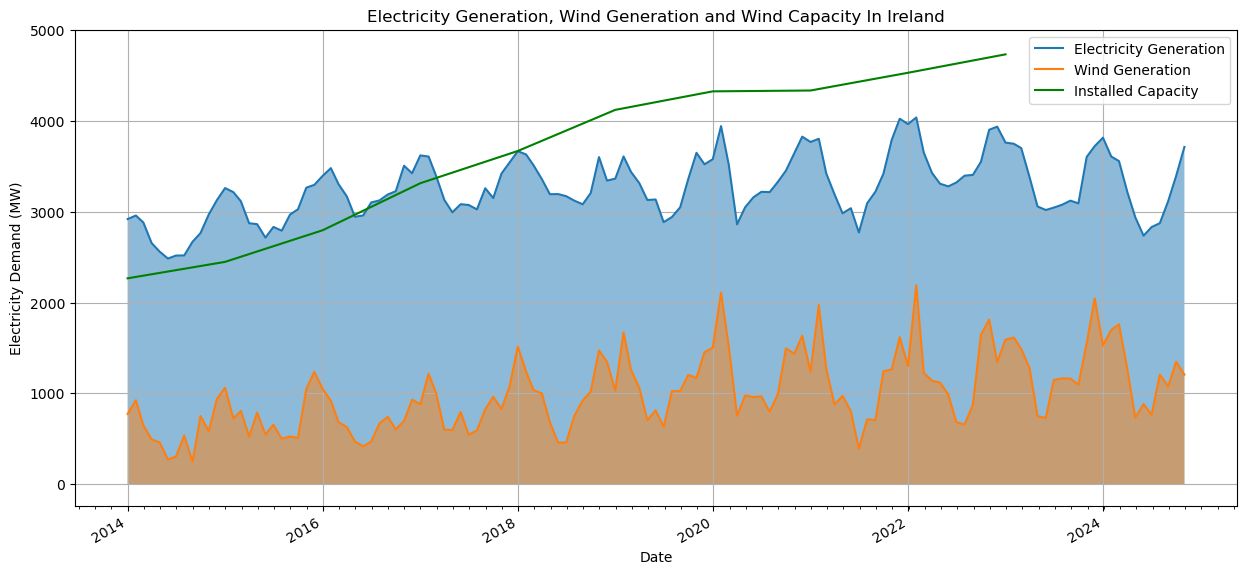

In [121]:
# Plot.
fig, ax = plt.subplots(figsize=(15, 7))

# Plot eirgrid data.
a = monthly_eirgrid_df['IE Generation']
b = monthly_eirgrid_df['IE Wind Generation']

# Fill between plots.
date = monthly_eirgrid_df.index
ax.fill_between(date, 0, a, alpha=0.5)
ax.fill_between(date, 0, b, alpha=0.5)

# Add outline to fill between plot.
ax.plot(a, label='Electricity Generation')
ax.plot(b, label='Wind Generation')

# Plot installed wind capacity.
x = wind_capacity[wind_capacity.index > '2013-12-31']
ax.plot(x, label='Installed Capacity', color='green')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(12))
fig.autofmt_xdate()

yticks = np.arange(0, 6000, 1000)
ax.set_yticks(yticks)

ax.set_ylabel('Electricity Demand (MW)')
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title('Electricity Generation, Wind Generation and Wind Capacity In Ireland')
ax.legend()

plt.show()

I have calculated an average wind energy share of 36% of overall electricity generation in Ireland since 2020.

I have also calculated a [capacity factor](https://www.seai.ie/sites/default/files/publications/Community-Toolkit-Onshore-Wind.pdf) of 27%, which measures the wind energy generated from a wind farm as a percentage of its maximum theoretical power output.

Both figures align with the figures expressed in the [SEAI Onshore Wind Report](https://www.seai.ie/sites/default/files/publications/Community-Toolkit-Onshore-Wind.pdf).

In [115]:
# Let's look at the share of electricity and capacity factor.
time_frame = '2020-01-01'

# Mean wind capacity from 2020 to present.
wind_cap = wind_capacity[wind_capacity.index >= time_frame
                         ]['Total'].mean()
print(f'Average installed wind capacity since 2020: {wind_cap:,.0f} (MW)')

# Mean wind generation from 2020 to present.
wind_gen = monthly_eirgrid_df[monthly_eirgrid_df.index >= time_frame
                              ]['IE Wind Generation'].mean()
print(f'Average wind energy generation since 2020: {wind_gen:,.0f} (MW)')

# Mean electricity generation from 2020 to present.
elec_gen = monthly_eirgrid_df[monthly_eirgrid_df.index >= time_frame
                              ]['IE Generation'].mean()
print(f'Average electricity energy generation since 2020: {elec_gen:,.0f} (MW)')

# Calculate wind share and capacity factor.
wind_share = (wind_gen/elec_gen) * 100
capacity = (wind_gen/wind_cap) * 100
print(f'Wind energy share of electricity energy generation: {wind_share:.2f}%')
print(f'Capacity factor: {capacity:.2f}%')

Average installed wind capacity since 2020: 4,479 (MW)
Average wind energy generation since 2020: 1,226 (MW)
Average electricity energy generation since 2020: 3,399 (MW)
Wind energy share of electricity energy generation: 36.07%
Capacity factor: 27.38%


### Predicting wind speeds into the future

I have used ``scikit-learn``'s [decision tree regression](https://scikit-learn.org/stable/modules/tree.html#regression) to predict wind speeds in 2025 based on the  historical Met Éireann wind speed data. The model score of 0.36 suggests that the model is not the best fit; however, the plot shows that the 2025 wind speed displays the expected seasonal trend.

In [116]:
# Dataframe to use to predict 2025 wind speed.
# Resample the Met Eireann hourly data.
monthly_df = hourly_df.resample('MS').mean()

# Add to dataframe.
monthly_wind = pd.DataFrame(monthly_df.mean(axis=1), columns=['wdsp'])

# Add month column.
monthly_wind['month'] = monthly_wind.index.month

# Remove 2025 data due to resample.
monthly_wind = monthly_wind[monthly_wind.index < '2025-01-01']

monthly_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 179 entries, 2010-02-01 to 2024-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wdsp    179 non-null    float64
 1   month   179 non-null    int32  
dtypes: float64(1), int32(1)
memory usage: 3.5 KB


Jan: 10.37
Feb: 11.05
Mar: 9.80
Apr: 9.00
May: 8.85
Jun: 8.25
Jul: 7.93
Aug: 8.52
Sep: 8.68
Oct: 9.38
Nov: 9.62
Dec: 10.89
Model score: 0.36003955363286666


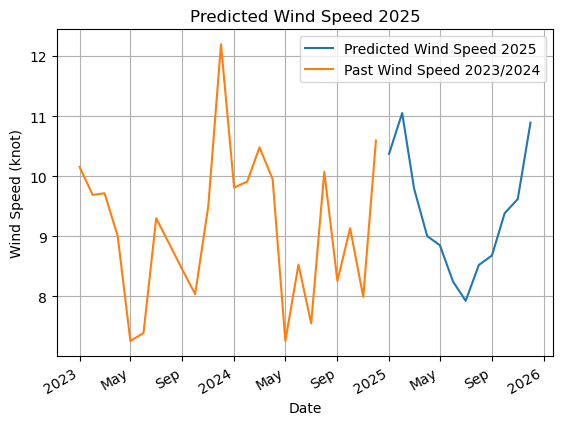

In [117]:
# Variables for the model.
x = monthly_wind[['month']]
y = monthly_wind['wdsp']

# Decicion tree regression model.
model = tree.DecisionTreeRegressor()
model = model.fit(x, y)

# Dataframe for predicting wind speed for each month of 2025.
months_2025 = pd.DataFrame({'month': np.arange(1, 13)})

# Use model to predict the wind speed.
wdsp_2025 = model.predict(months_2025)

# Print the predicted wind speeds.
months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month, wdsp in zip(months, wdsp_2025):
    print(f'{month}: {wdsp:.2f}')

# Print the model score.
print(f'Model score: {model.score(x, y)}')

# Create a dataframe for the 2025 wind speed.
fut_wind = pd.DataFrame({
    'wdsp': wdsp_2025,
    'month': np.arange(1, 13),
    'date': pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')})

# Filter past wind to include 2023/2034 data for plotting.
past_wind = monthly_wind[monthly_wind.index > '2022-12-31']

# Plot.
fig, ax = plt.subplots()

# Plot 2025 wind.
ax.plot(fut_wind['date'], fut_wind['wdsp'], label='Predicted Wind Speed 2025')

# Plot 2023/2024 wind.
ax.plot(past_wind['wdsp'], label='Past Wind Speed 2023/2024')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)

fig.autofmt_xdate()

ax.set_ylabel('Wind Speed (knot)')
ax.set_xlabel('Date')
ax.set_title('Predicted Wind Speed 2025')
ax.legend()

ax.grid()

plt.show()

***
## End